<a href="https://colab.research.google.com/github/NeulboGom/J_Automation_Project/blob/JH/Anomaly_Detection_Xception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
from glob import glob
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image
import pandas as pd
import csv
import numpy as np
import tensorflow as tf
from tensorflow import keras
import albumentations as albu
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, SeparableConv2D, BatchNormalization, GlobalAveragePooling2D, Dense

# 모델 가져오기

## Xception 모델과 유사하게 구현

  

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, SeparableConv2D, BatchNormalization, GlobalAveragePooling2D, Dense, Add
from tensorflow.keras.models import Model

# Xception 스타일의 네트워크 정의
def XceptionStyleClassification(input_shape=(224, 224, 3), num_classes=3):  # num_classes는 클래스 수에 맞게 조정
    input_tensor = Input(shape=input_shape)

    # Entry Flow
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_tensor)
    x = BatchNormalization()(x)

    # Separable Convolution Blocks
    for _ in range(1):
        residual = x
        x = SeparableConv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = SeparableConv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        residual = SeparableConv2D(64, (3, 3), activation='relu', padding='same')(residual)  # Skip Connection 크기 조정
        x = Add()([residual, x])  # Skip Connection

    # Middle Flow
    x = SeparableConv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    # Exit Flow
    x = SeparableConv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = GlobalAveragePooling2D()(x)

    # Classification Layer with softmax activation
    x = Dense(num_classes, activation='softmax')(x)  # 다중 클래스 분류

    model = Model(inputs=input_tensor, outputs=x)

    return model

# 모델 생성
num_classes = 3  # 분류할 클래스 수에 맞게 조정
model = XceptionStyleClassification(num_classes=num_classes)

# 모델 요약 출력
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 224, 224, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

# 이미지 데이터 전처리

In [4]:
def preprocess_image(image_path, target_size=(224, 224)):
    # 이미지 파일 경로 불러오기
    image_list = glob(os.path.join(image_path, '*.png'))

    # 빈 numpy 배열 생성 (4차원 배열로 초기화)
    img_array = np.empty((len(image_list), *target_size, 3), dtype=np.uint8)

    for i, img in enumerate(image_list):
        image = Image.open(img)
        image = image.resize(target_size)

        # 흑백 이미지를 3차원 RGB 형태로 변경
        image = image.convert('RGB')

        img_array[i] = np.array(image)

    return img_array


## Train, Validation, Test 데이터 나누기

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# 정상(normal) 데이터와 이상(abnormal) 데이터 준비
X_normal = preprocess_image('/content/drive/MyDrive/Project/up/good_up')
X_abnormal = preprocess_image('/content/drive/MyDrive/Project/up/notgood_up')
X_check = preprocess_image('/content/drive/MyDrive/Project/up/check_up')

# 레이블 생성
# 정상 0, 비정상 1, 체크 2
y_normal = np.zeros(len(X_normal))
y_abnormal = np.ones(len(X_abnormal))
y_check = np.full(len(X_check), 2)

# 클래스 불균형 해결 (오버샘플링)
X_abnormal_upsampled, y_abnormal_upsampled = resample(X_abnormal, y_abnormal, n_samples=len(X_normal), random_state=42)

# 복제한 이상 데이터를 정상 데이터와 합치기
X_combined = np.concatenate((X_normal, X_abnormal_upsampled, X_check), axis=0)
y_combined = np.concatenate((y_normal, y_abnormal_upsampled, y_check), axis=0)

# 데이터를 train, validation, test 데이터로 나누기
X_train, X_temp, y_train, y_temp = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)


In [6]:
# Data Shape 확인
print("Train data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)
print("Test data shape:", X_test.shape)

Train data shape: (902, 224, 224, 3)
Validation data shape: (180, 224, 224, 3)
Test data shape: (46, 224, 224, 3)


## Data Normalization, augmentation

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 데이터 증강을 위한 ImageDataGenerator 생성
datagen = ImageDataGenerator(
    rotation_range=60,          # 이미지 회전 범위 설정
    width_shift_range=0.05,      # 이미지 가로 이동 범위 설정
    height_shift_range=0.05,     # 이미지 세로 이동 범위 설정
    shear_range=0.1,            # 이미지 전단 변환 범위 설정
    zoom_range=0.2,             # 이미지 확대/축소 범위 설정
    horizontal_flip=True,       # 이미지 수평 뒤집기 설정
    vertical_flip=True,         # 이미지 수직 뒤집기 설정
    fill_mode='nearest',        # 이미지 편형 시 채워지는 값의 방식 설정
    brightness_range=[0.5, 1.5],  # 이미지 밝기 변화 범위 설정
)

# Augmentation을 적용하여 데이터를 증강
augmented_images = []
augmented_labels = []
for image, label in zip(X_train, y_train):
    # 이미지를 3D 배열로 변환 (높이, 너비, 채널)
    image_3d = image[:, :, :3]  # 채널 정보만 가져오기
    augmented_image = datagen.random_transform(image_3d)
    augmented_images.append(augmented_image)
    augmented_labels.append(label)

augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

# 증강된 이미지와 레이블을 기존 데이터와 병합
X_train = np.concatenate((X_train, augmented_images), axis=0)
y_train = np.concatenate((y_train, augmented_labels), axis=0)

# 증강 후의 이미지 개수와 레이블 개수 확인
print("X_train shape after augmentation:", X_train.shape)
print("y_train shape after augmentation:", y_train.shape)



X_train shape after augmentation: (1804, 224, 224, 3)
y_train shape after augmentation: (1804,)


In [7]:
# Convert the images to float32 and then normalize by dividing by 255
X_train = X_train / 255
X_val = X_val / 255
X_test = X_test / 255

# Model compile

In [8]:
from keras.callbacks import ReduceLROnPlateau

# ReduceLROnPlateau 콜백 설정
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=3, min_lr=0.000001, verbose=1)


In [9]:
from tensorflow.keras.optimizers import Adam, SGD

model.compile(optimizer = Adam(learning_rate = 0.0001),
                       loss = 'sparse_categorical_crossentropy',
                       metrics = ['accuracy'])

# 모델 Train, test

## Model Train

In [ ]:
# eager mode 실행
tf.config.run_functions_eagerly(True)

In [10]:
EPOCH = 30
BATCH_SIZE = 16

# 모델 훈련
history = model.fit(X_train, y_train, epochs = EPOCH,
                             batch_size = BATCH_SIZE,
                             validation_data = (X_val, y_val), verbose = 1,
                             callbacks = [reduce_lr])

Epoch 1/30
113/113 [==============================] - 47s 263ms/step - loss: 0.9181 - accuracy: 0.6414 - val_loss: 1.0895 - val_accuracy: 0.4833 - lr: 1.0000e-04
Epoch 2/30
113/113 [==============================] - 27s 241ms/step - loss: 0.7776 - accuracy: 0.7167 - val_loss: 1.0914 - val_accuracy: 0.4833 - lr: 1.0000e-04
Epoch 3/30
113/113 [==============================] - 28s 245ms/step - loss: 0.7055 - accuracy: 0.7528 - val_loss: 1.1136 - val_accuracy: 0.4833 - lr: 1.0000e-04
Epoch 4/30
113/113 [==============================] - 28s 245ms/step - loss: 0.6566 - accuracy: 0.7622 - val_loss: 1.0951 - val_accuracy: 0.5333 - lr: 1.0000e-04
Epoch 5/30
113/113 [==============================] - 28s 248ms/step - loss: 0.6255 - accuracy: 0.7772 - val_loss: 1.1831 - val_accuracy: 0.5111 - lr: 1.0000e-04
Epoch 6/30
113/113 [==============================] - 28s 250ms/step - loss: 0.5919 - accuracy: 0.7816 - val_loss: 0.7367 - val_accuracy: 0.8167 - lr: 1.0000e-04
Epoch 7/30
113/113 [========

In [ ]:
EPOCH = 30
BATCH_SIZE = 20

# 모델 훈련
history = model.fit(X_train, y_train, epochs = EPOCH,
                    batch_size = BATCH_SIZE,
                    validation_data = (X_val, y_val),
                    verbose = 1)

### Train, Validation loss Graph

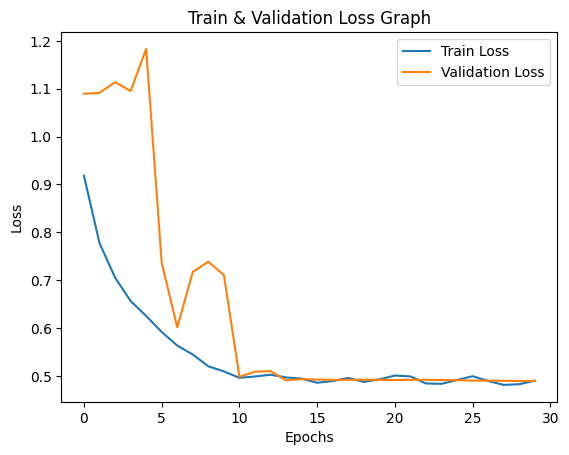

In [11]:
plt.plot(history.history['loss'], label = 'Train Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.title('Train & Validation Loss Graph')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Accuracy Graph

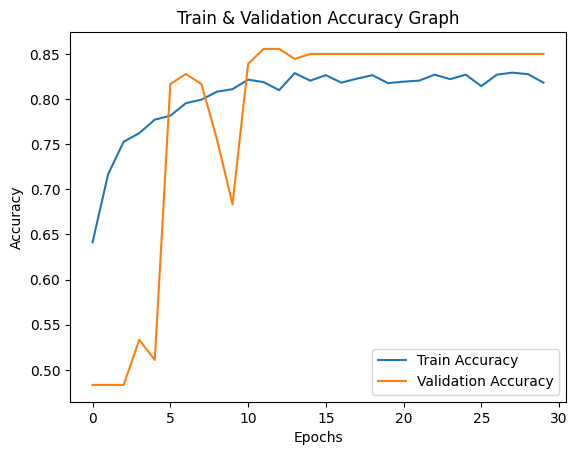

In [12]:
plt.plot(history.history['accuracy'], label = 'Train Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('Train & Validation Accuracy Graph')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Model Test

In [13]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss: ", test_loss)
print("Test Accuracy:", test_accuracy)

2/2 [==============================] - 2s 569ms/step - loss: 0.4388 - accuracy: 0.8696
Test Loss:  0.4387907087802887
Test Accuracy: 0.8695651888847351


# 폐기

In [7]:
# 데이터 증강을 위한 ImageDataGenerator 생성
datagen = ImageDataGenerator(
    rotation_range=60,          # 이미지 회전 범위 설정
    width_shift_range=0.05,      # 이미지 가로 이동 범위 설정
    height_shift_range=0.05,     # 이미지 세로 이동 범위 설정
    shear_range=0.1,            # 이미지 전단 변환 범위 설정
    zoom_range=0.2,             # 이미지 확대/축소 범위 설정
    horizontal_flip=True,       # 이미지 수평 뒤집기 설정
    vertical_flip=True,         # 이미지 수직 뒤집기 설정
    fill_mode='nearest',        # 이미지 편형 시 채워지는 값의 방식 설정
    brightness_range=[0.5, 1.5],  # 이미지 밝기 변화 범위 설정
)

# Augmentation을 적용하여 데이터를 증강
augmented_images = []
augmented_labels = []
for image, label in zip(X_val, y_val):
    # 이미지를 3D 배열로 변환 (높이, 너비, 채널)
    image_3d = image[:, :, :3]  # 채널 정보만 가져오기
    augmented_image = datagen.random_transform(image_3d)
    augmented_images.append(augmented_image)
    augmented_labels.append(label)

augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

# 증강된 이미지와 레이블을 기존 데이터와 병합
X_val = np.concatenate((X_val, augmented_images), axis=0)
y_val = np.concatenate((y_val, augmented_labels), axis=0)

# 증강 후의 이미지 개수와 레이블 개수 확인
print("X_val shape after augmentation:", X_val.shape)
print("y_val shape after augmentation:", y_val.shape)



X_val shape after augmentation: (360, 224, 224, 3)
y_val shape after augmentation: (360,)
